# Notebook to try additional features

In [2]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

In [3]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)


C:\Users\kasj\AppData\Local\Temp\ipykernel_20004\1073794623.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [4]:
data.columns

Index(['RGIID', 'GLIMSID', 'BREID', 'utm_zone', 'utm_east_approx',
       'utm_north_approx', 'altitude_approx', 'location_description',
       'location_id', 'stake_no',
       ...
       'tp_jan', 'tp_feb', 'tp_mar', 'tp_apr', 'tp_may', 'tp_jun', 'tp_jul',
       'tp_aug', 'tp_sep', 'altitude_climate'],
      dtype='object', length=301)

In [5]:
# Compute continentality index for each row
# cidx= (1.7*A / sin(lat + 10deg) - 14 where A is highest mean monthly temp - lowest mean monthly temp

temp_cols = ['t2m_oct', 't2m_nov', 't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar', 't2m_apr', 't2m_may', 't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep'] 

# Calculate maximum and minimum monthly mean temperatures for each row
data['T_max'] = data[temp_cols].max(axis=1)
data['T_min'] = data[temp_cols].min(axis=1)

# Calculate the continentality index using Gorczynski's formula
data['cidx'] = 1.7 * (data['T_max'] - data['T_min']) / np.sin(np.radians(data['lat'] + 10)) + 14

# Printing the DataFrame to see the result
print(data[['RGIID', 'GLIMSID', 'BREID', 'lat', 'T_max', 'T_min', 'cidx']].head())



            RGIID         GLIMSID  BREID        lat       T_max       T_min  \
0  RGI60-08.01258  G021737E70130N     54  70.125889  283.829285  261.676819   
1  RGI60-08.01258  G021737E70130N     54  70.125784  286.991089  262.563507   
2  RGI60-08.01258  G021737E70130N     54  70.125732  284.425964  261.710236   
3  RGI60-08.01258  G021737E70130N     54  70.125732  284.442657  261.301056   
4  RGI60-08.01258  G021737E70130N     54  70.125536  283.518036  265.597778   

        cidx  
0  52.225429  
1  56.151293  
2  53.197392  
3  53.932262  
4  44.922529  


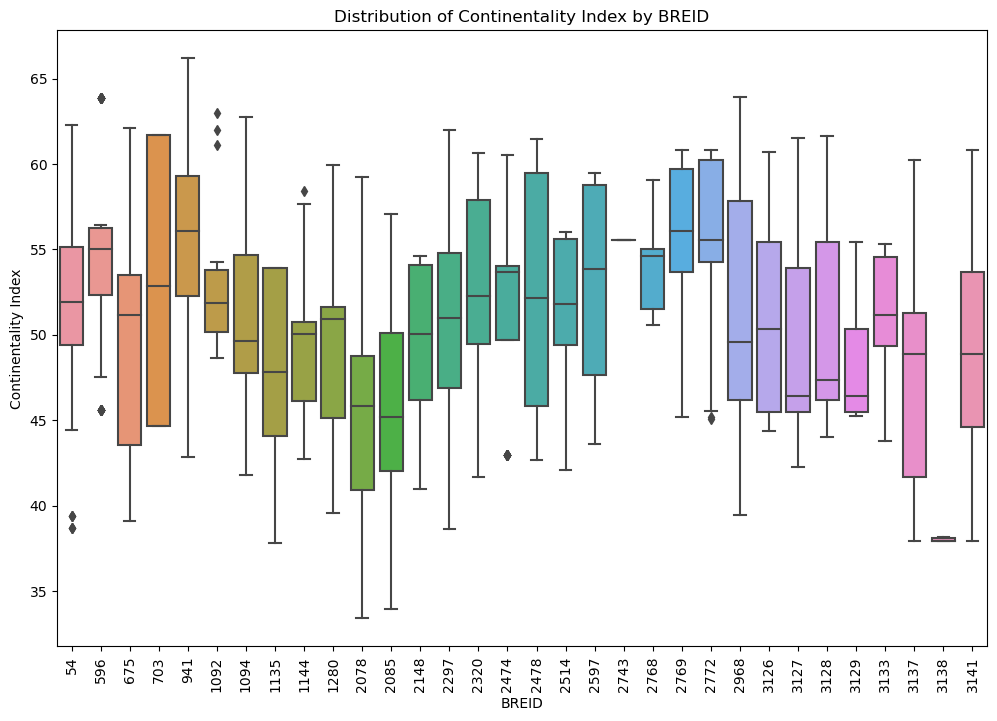

In [6]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='BREID', y='cidx')
plt.title('Distribution of Continentality Index by BREID')
plt.xlabel('BREID')
plt.ylabel('Continentality Index')
plt.xticks(rotation=90)  # Rotate x labels if there are many BREID categories
plt.show()

In [7]:
data = data.drop(columns=['T_max', 'T_min'])
data.head()

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,cidx
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,52.225429
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,56.151293
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,53.197392
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,53.932262
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,44.922529


In [16]:
# Save dataframe with latitude and longitude 

#filename_cidx = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_cidx.csv'

#data.to_csv(filepath + filename_cidx, index=False)  

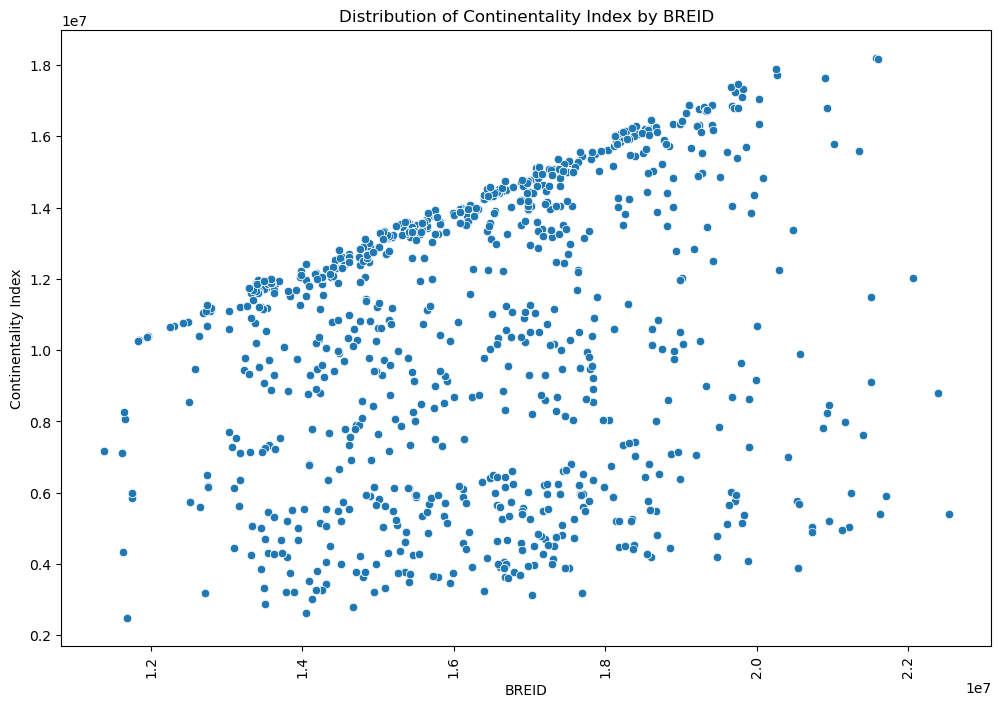

In [56]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='ssrd_jul')
plt.title('Distribution of Continentality Index by BREID')
plt.xlabel('BREID')
plt.ylabel('Continentality Index')
plt.xticks(rotation=90)  # Rotate x labels if there are many BREID categories
plt.show()